<a href="https://colab.research.google.com/github/emrllh/My_works/blob/main/Reusing_the_A_Keras_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reusing the A Keras Model

Reusing a Keras model
Let's split the fashion MNIST training set in two:

X_train_A: all images of all items except for T-shirts/tops and pullovers (classes 0 and 2).

X_train_B: a much smaller training set of just the first 200 images of T-shirts/tops and pullovers.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification).

 We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (trousers, dresses, coats, sandals, shirts, sneakers, bags, and ankle boots) are somewhat similar to classes in set B (T-shirts/tops and pullovers). However, since we are using Dense layers, only patterns that occur at the same location can be reused.

  (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the chapter 14).

In [ ]:
import keras
import tensorflow as tf
import numpy as np

In [ ]:
#load the Fasion Mnist Dataset
(X_train_full,y_train_full),(X_test,y_test)=keras.datasets.fashion_mnist.load_data()

In [ ]:
X_train,X_valid=X_train_full[:50000]/255,X_train_full[50000:]/255
y_train,y_valid=y_train_full[:50000],y_train_full[50000:]
X_test=X_test/255

In [ ]:
#Checking data shape
X_train_full.shape,y_train_full.shape,X_test.shape,y_test.shape,X_valid.shape,y_valid.shape

((60000, 28, 28),
 (60000,),
 (10000, 28, 28),
 (10000,),
 (10000, 28, 28),
 (10000,))

In [ ]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [ ]:
pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # reorder class ids for A
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [ ]:
#pos_class_id=class_names.index('Pullover')
#neg_class_id=class_names.index('T-shirt/top')
#pos_class_id,neg_class_id

(2, 0)

def split_dataset(X,y):
  y_for_B=(y==pos_class_id) | (y==neg_class_id)
  y_A =y[~y_for_B]
  y_B=(y[y_for_B]==pos_class_id).astype(np.float32)

  old_class_ids=list(set(range(10))-set([neg_class_id,pos_class_id]))

  for old_class_id,new_class_id in zip(old_class_ids,range(8)):
    y_A[y_A==old_class_id]=new_class_id #reorder class ids for A
    
    return((X[~y_for_B],y_A),(X[y_for_B],y_B))

(X_train_A,y_train_A),(X_train_B,y_train_B)=split_dataset(X_train,y_train)
(X_valid_A,y_valid_A),(X_valid_B,y_valid_B)=split_dataset(X_valid,y_valid)
(X_test_A,y_test_A),(X_test_B,y_test_B)=split_dataset(X_test,y_test)
X_train_B=X_train_B[:200]
y_train_B=y_train_B[:200]

In [ ]:
X_train_A.shape,X_valid_A.shape,y_train_A.shape,y_valid_A.shape

((40031, 28, 28), (7969, 28, 28), (40031,), (7969,))

In [ ]:

#creating a function for the model
def create_model():
 #creating the model
 model=tf.keras.Sequential([tf.keras.layers.Flatten(input_shape=(28,28)),
                            tf.keras.layers.Dense(100,activation='relu',kernel_initializer="he_normal"),
                            tf.keras.layers.Dense(100,activation='relu',kernel_initializer="he_normal"),
                            tf.keras.layers.Dense(100,activation='relu',kernel_initializer="he_normal"),
                            tf.keras.layers.Dense(8,activation='softmax')
 ])

 #compile the model
 model.compile(loss='sparse_categorical_crossentropy',
               optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
               metrics=['accuracy'])

 return model

In [ ]:
model_A=create_model()
model_A.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_20 (Dense)            (None, 100)               78500     
                                                                 
 dense_21 (Dense)            (None, 100)               10100     
                                                                 
 dense_22 (Dense)            (None, 100)               10100     
                                                                 
 dense_23 (Dense)            (None, 8)                 808       
                                                                 
Total params: 99508 (388.70 KB)
Trainable params: 99508 (388.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                      validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1251/1251 [==============================] - 6s 4ms/step - loss: 1.1990 - accuracy: 0.6164 - val_loss: 0.7479 - val_accuracy: 0.7445
Epoch 2/20
1251/1251 [==============================] - 6s 5ms/step - loss: 0.6356 - accuracy: 0.7911 - val_loss: 0.5551 - val_accuracy: 0.8155
Epoch 3/20
1251/1251 [==============================] - 5s 4ms/step - loss: 0.5114 - accuracy: 0.8350 - val_loss: 0.4730 - val_accuracy: 0.8425
Epoch 4/20
1251/1251 [==============================] - 7s 5ms/step - loss: 0.4461 - accuracy: 0.8571 - val_loss: 0.4269 - val_accuracy: 0.8539
Epoch 5/20
1251/1251 [==============================] - 5s 4ms/step - loss: 0.4053 - accuracy: 0.8674 - val_loss: 0.3951 - val_accuracy: 0.8637
Epoch 6/20
1251/1251 [==============================] - 5s 4ms/step - loss: 0.3772 - accuracy: 0.8740 - val_loss: 0.3742 - val_accuracy: 0.8705
Epoch 7/20
1251/1251 [==============================] - 6s 5ms/step - loss: 0.3568 - accuracy: 0.8793 - val_loss: 0.3593 - val_accuracy:

In [ ]:
history.params



{'verbose': 1, 'epochs': 20, 'steps': 1251}

<Axes: xlabel='epochs'>

<Figure size 700x300 with 0 Axes>

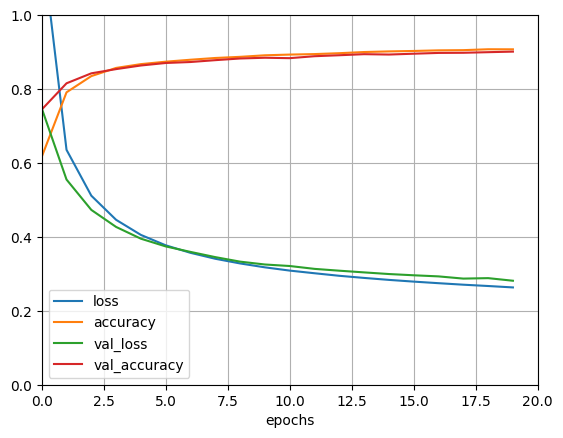

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize=(7,3))
pd.DataFrame(history.history).plot(xlim=[0,20],ylim=[0,1],grid='True',
                                   xlabel='epochs')

In [ ]:
#creating model_B
tf.random.set_seed(42)

model_B=tf.keras.Sequential([
                            tf.keras.layers.Flatten(input_shape=[28,28]),
                            tf.keras.layers.Dense(100,activation='relu'),
                             tf.keras.layers.Dense(100,activation='relu'),
                             tf.keras.layers.Dense(100,activation='relu'),
                             tf.keras.layers.Dense(1,activation='sigmoid')
                             ])

In [ ]:
#compile the model_B
model_B.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=['accuracy'])

In [ ]:
#fitting the model_B
model_B.fit(X_train_B,y_train_B,epochs=20,
            validation_data=(X_valid_B,y_valid_B))

Epoch 1/20
7/7 [==============================] - 2s 87ms/step - loss: 0.7140 - accuracy: 0.3900 - val_loss: 0.7118 - val_accuracy: 0.3796
Epoch 2/20
7/7 [==============================] - 0s 28ms/step - loss: 0.7058 - accuracy: 0.4400 - val_loss: 0.7047 - val_accuracy: 0.4313
Epoch 3/20
7/7 [==============================] - 1s 112ms/step - loss: 0.6983 - accuracy: 0.4950 - val_loss: 0.6981 - val_accuracy: 0.4791
Epoch 4/20
7/7 [==============================] - 0s 33ms/step - loss: 0.6908 - accuracy: 0.5450 - val_loss: 0.6920 - val_accuracy: 0.5234
Epoch 5/20
7/7 [==============================] - 0s 29ms/step - loss: 0.6842 - accuracy: 0.5850 - val_loss: 0.6856 - val_accuracy: 0.5800
Epoch 6/20
7/7 [==============================] - 0s 29ms/step - loss: 0.6775 - accuracy: 0.6300 - val_loss: 0.6797 - val_accuracy: 0.6327
Epoch 7/20
7/7 [==============================] - 0s 33ms/step - loss: 0.6713 - accuracy: 0.6750 - val_loss: 0.6741 - val_accuracy: 0.6731
Epoch 8/20
7/7 [==========

In [ ]:
#evaluating model_B
model_B.evaluate(X_test_B,y_test_B)

63/63 [==============================] - 0s 3ms/step - loss: 0.6160 - accuracy: 0.8745


[0.6160337328910828, 0.8744999766349792]

In [ ]:
#Model B reaches 91.85% accuracy on the test set. Now let's try reusing the pretrained model A.
# To not affect the actual model_A we use clone method to copy it

model_A_clone=tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [ ]:
#creating model_B_on_A just like in the previous cell

model_B_on_A=tf.keras.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1,activation='sigmoid'))

In [ ]:
optimizer=tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss='binary_crossentropy',
                     optimizer=optimizer,
                     metrics=['accuracy'])

###We are going to train model_B_on_A with model_A wights and without and see the result

In [ ]:
for layer in model_B_on_A.layers[:-1]:
  layer.trainable=False

In [ ]:
history=model_B_on_A.fit(X_train_B,y_train_B,epochs=20,
                       validation_data=(X_valid_B,y_valid_B))

Epoch 1/20
7/7 [==============================] - 1s 60ms/step - loss: 1.4428 - accuracy: 0.1150 - val_loss: 1.3981 - val_accuracy: 0.1265
Epoch 2/20
7/7 [==============================] - 0s 25ms/step - loss: 1.3912 - accuracy: 0.1000 - val_loss: 1.3595 - val_accuracy: 0.1137
Epoch 3/20
7/7 [==============================] - 0s 29ms/step - loss: 1.3496 - accuracy: 0.1200 - val_loss: 1.3440 - val_accuracy: 0.1192
Epoch 4/20
7/7 [==============================] - 0s 26ms/step - loss: 1.2949 - accuracy: 0.1150 - val_loss: 1.3040 - val_accuracy: 0.1231
Epoch 5/20
7/7 [==============================] - 0s 28ms/step - loss: 1.2618 - accuracy: 0.1350 - val_loss: 1.2570 - val_accuracy: 0.1270
Epoch 6/20
7/7 [==============================] - 0s 31ms/step - loss: 1.2231 - accuracy: 0.1350 - val_loss: 1.2173 - val_accuracy: 0.1349
Epoch 7/20
7/7 [==============================] - 0s 35ms/step - loss: 1.1831 - accuracy: 0.1350 - val_loss: 1.1797 - val_accuracy: 0.1502
Epoch 8/20
7/7 [===========

###Without the accuracy droped drastically

In [ ]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))


In [ ]:
for layer in model_B_on_A.layers[:-1]:
  layer.trainable=True

In [ ]:
optimizer=tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(optimizer=optimizer,
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

history=model_B_on_A.fit(X_train_B,y_train_B,epochs=20,
                         validation_data=(X_valid_B,y_valid_B))

Epoch 1/20
7/7 [==============================] - 1s 92ms/step - loss: 0.7574 - accuracy: 0.4400 - val_loss: 0.7127 - val_accuracy: 0.5367
Epoch 2/20
7/7 [==============================] - 0s 29ms/step - loss: 0.6461 - accuracy: 0.5800 - val_loss: 0.6090 - val_accuracy: 0.6928
Epoch 3/20
7/7 [==============================] - 0s 28ms/step - loss: 0.5544 - accuracy: 0.7300 - val_loss: 0.5537 - val_accuracy: 0.7233
Epoch 4/20
7/7 [==============================] - 0s 28ms/step - loss: 0.4820 - accuracy: 0.8200 - val_loss: 0.4932 - val_accuracy: 0.8242
Epoch 5/20
7/7 [==============================] - 0s 32ms/step - loss: 0.4352 - accuracy: 0.8700 - val_loss: 0.4482 - val_accuracy: 0.8685
Epoch 6/20
7/7 [==============================] - 0s 32ms/step - loss: 0.4004 - accuracy: 0.8750 - val_loss: 0.4173 - val_accuracy: 0.8877
Epoch 7/20
7/7 [==============================] - 0s 32ms/step - loss: 0.3698 - accuracy: 0.9000 - val_loss: 0.3965 - val_accuracy: 0.8946
Epoch 8/20
7/7 [===========

In [ ]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 3ms/step - loss: 0.2684 - accuracy: 0.9315


[0.2684090733528137, 0.9315000176429749]

### Very big improvement on model_B_on_A for reusing model_A with the weights